In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
from sklearn.datasets import make_regression, make_classification, make_blobs
import matplotlib.pyplot as plt
import numpy as np

(80, 1)
(20, 1)
(80,)
(20,)


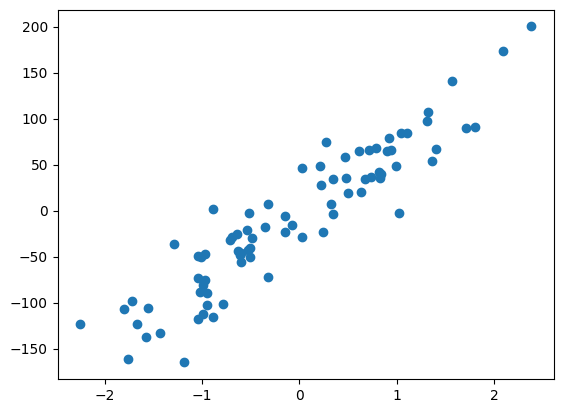

In [ ]:
X, y = make_regression(n_samples=100, n_features=1, noise=30, random_state=50042)

train_x=X[:-20]
test_x=X[-20:]

train_y=y[:-20]
test_y=y[-20:]
plt.scatter(train_x,train_y)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

## Cost Function: Minimum Squares

$$
\begin{split}
  \mathcal{L}(m, b) &= \frac{1}{N}\sum_{i=1}^{N}(\hat{y} - y)^2 \\
  \mathcal{L}(m, b) &= \frac{1}{N}\sum_{i=1}^{N}(mx_{i} + b - y_i)^2
\end{split}
$$

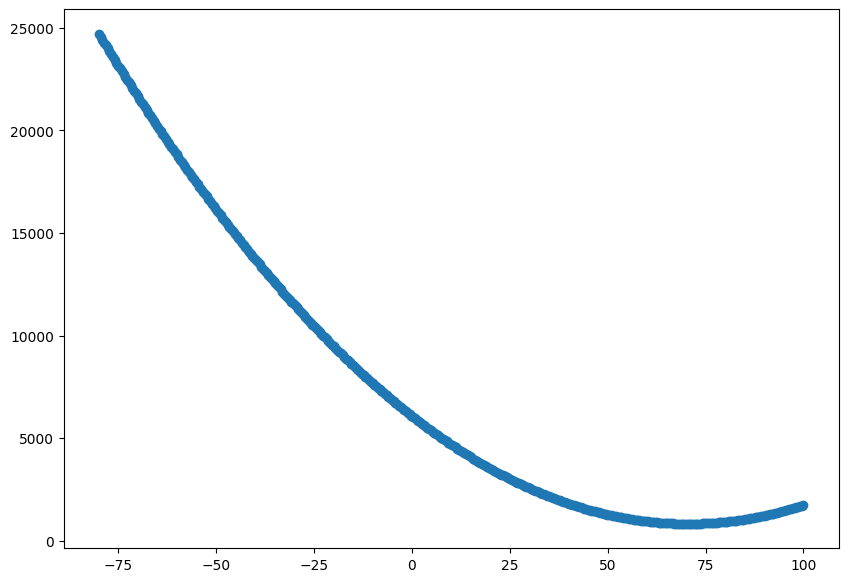

In [ ]:
def cost(x, y, m, b):
  return 1/len(x) * np.sum((m * x + b - y)**2)


x = train_x.reshape((80,))
m_values = np.linspace(-80, 100, 400)
cost_vals = np.array([cost(x, train_y, m, 0) for m in m_values])

fig = plt.figure(figsize=(10, 7))
plt.scatter(m_values, cost_vals)
plt.show()

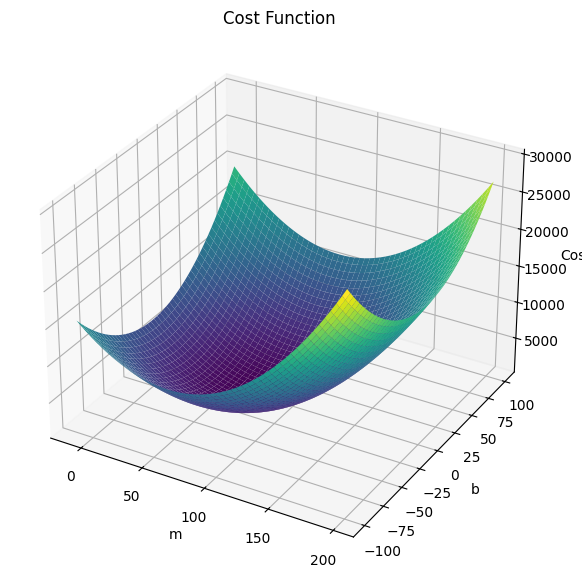

In [ ]:
m_values = np.linspace(-10, 200, 300)
b_values = np.linspace(-100, 100, 300)

# Matrix with combinations of m and b
M, B = np.meshgrid(m_values, b_values)

# Generate costs using the meshgrid
Z = np.array([[cost(x, train_y,m, b) for m in m_values] for b in b_values])

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d') # Use subplot for 3D
ax.plot_surface(M, B, Z, cmap='viridis')

ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('Cost')
ax.set_title('Cost Function')

plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=M, y=B, colorscale='Viridis')])

fig.update_layout(
    title="Cost Function (Interactive)",
    scene=dict(
        xaxis_title='m',
        yaxis_title='b',
        zaxis_title='Error'
    )
)
# The interactive plot shows contours, this is useful because
# the contour for the minimum only has 1 point (the min)
fig.show()

# Gradient Descent

For a vector of parameters $\theta$, the gradient descent algorithm moves opposite to the gradient of the cost function $\nabla\mathcal{L}$, with a learning rate $\gamma$ to reach a local minimum using the recurrence:
$$\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \gamma\nabla\mathcal{L}
$$

## Linear Regression

For a single variable linear regression

$$\hat{y} = \begin{bmatrix}1 & x\end{bmatrix}\begin{bmatrix}b \\ m\end{bmatrix} = mx + b$$

the gradient is obtained as follows.

### Partial derivative with respect to the independent term
$$\begin{split}
∂_{b}\mathcal{L}(m, b) &= \frac{\partial}{\partial b}\left(\frac{1}{N}\sum_{i=1}^{N}(mx_{i} + b - y)^2\right)\\
           &= \frac{1}{N}\sum_{i=1}^{N}\frac{\partial}{\partial b}\left(mx_{i} + b - y\right)^2\\
          &= \frac{1}{N}\sum_{i=1}^{N}2\left(mx_{i} + b - y\right)\cdot\frac{\partial}{\partial b}\left(mx_{i} + b\right)\\
          &= \frac{1}{N}\sum_{i=1}^{N}2\left(\hat{y} - y\right)
\end{split}$$

### Partial derivative with respect to the slope
$$\begin{split}
∂_{m}\mathcal{L}(m, b) &= \frac{\partial}{\partial m}\left(\frac{1}{N}\sum_{i=1}^{N}(\hat{y} - y)^2\right)\\
           &= \frac{1}{N}\sum_{i=1}^{N}\frac{\partial}{\partial m}\left(mx_i + b - y \right)^2\\
           &= \frac{1}{N}\sum_{i=1}^{N}2\left(mx_{i} + b - y\right)\cdot\frac{\partial}{\partial m}\left(mx_{i} + b - y \right)\\
          &= \frac{1}{N}\sum_{i=1}^{N}2\left(\hat{y} - y\right)\cdot x_{i}
\end{split}$$

### Gradient
$$\nabla \mathcal{L} = \begin{bmatrix}
  \frac{2}{N}\sum_{i=1}^{N}\left(\hat{y} - y\right) \\
  \frac{2}{N}\sum_{i=1}^{N}\left(\hat{y} - y\right)\cdot x_{i}
\end{bmatrix}$$

In [ ]:
def cost(x, y, params):
  b, m = params
  return 1/len(x) * np.sum((m*x + b - y) ** 2)

def gradient(x, y, params):
  b, m = params
  const = 2 / len(x)
  diff = m*x + b - y
  res = np.array([const * np.sum(diff),
                   const * np.sum(diff * x)])

  return np.array([const * np.sum(diff),
                   const * np.sum(diff * x)])

def gradientDescent(x, y,
                    cost,
                    gradient,
                    initial_params,
                    learning_rate,
                    epsilon = 1e-10,
                    max_iters = 300):
  if learning_rate(1) < 0:
    raise Exception("Invalid learning rate")
  elif epsilon < 0:
    raise Exception("Invalid epsilon")
  elif len(x.shape) > 1:
    raise Exception("Incorrect x format, use a 1 dimensional array")
  elif len(y.shape) > 1:
    raise Exception("Incorrect y format, use a 1 dimensional array")

  memo = []

  params = initial_params.copy()
  memo.append(params)

  cost_val = cost(x, y, params)
  iters = 1

  while True:
    params = params - learning_rate(iters) * gradient(x, y, params)
    memo.append(params)

    prev_cost = cost_val
    cost_val = cost(x, y, params)
    if abs(cost_val - prev_cost) < epsilon or iters >= max_iters:
      b_values = [v[0] for v in memo]
      m_values = [v[1] for v in memo]
      iters_range = np.arange(len(b_values))
      fig, axes = plt.subplots(1, 2, figsize=(12, 5))
      axes[0].set_title(f"b values per iter")
      axes[0].plot(iters_range,
                   b_values,
                  'salmon',
                  linewidth=2)
      axes[1].set_title(f"m values per iter")
      axes[1].plot(iters_range,
                   m_values,
                  'blue',
                  linewidth=2);

      print(f"b: {params[0]}")
      print(f"m: {params[1]}")
      print(f"Iters: {iters}")
      return params


    iters += 1

b: -3.2147071501257765
m: 70.34864620733372
Iters: 100


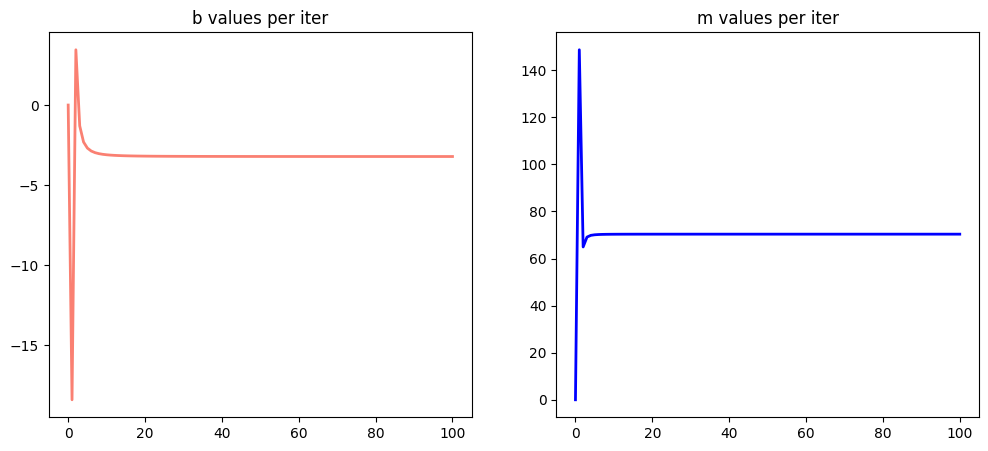

In [ ]:
params = gradientDescent(train_x.reshape((len(train_x),)),
                         train_y,
                         cost=cost,
                         gradient=gradient,
                         initial_params=np.array([0,0]),
                         learning_rate=lambda x: 1/x,
                         max_iters=100)

b: -3.215664740996184
m: 70.34854205591779
Iters: 72


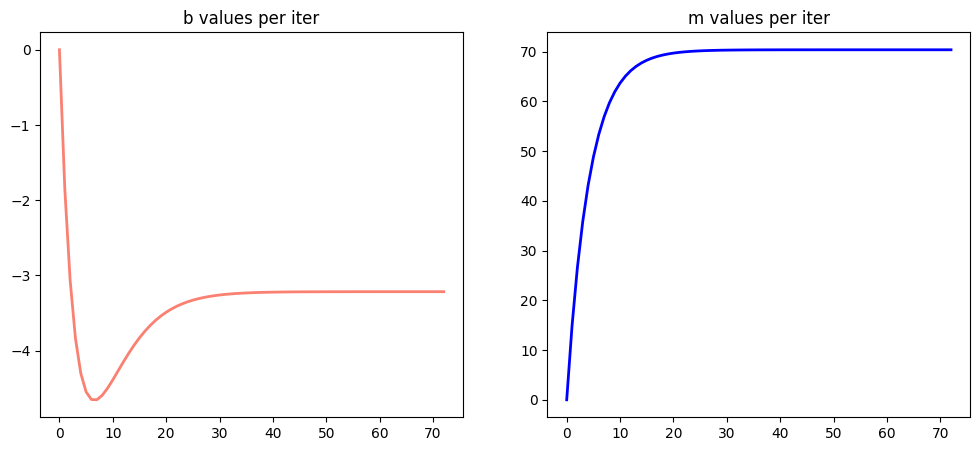

In [ ]:
params = gradientDescent(train_x.reshape((len(train_x),)),
                         train_y,
                         cost=cost,
                         gradient=gradient,
                         initial_params=np.array([0,0]),
                         learning_rate=lambda x: 0.1,
                         max_iters=100)

b: -3.215693512924723
m: 70.34851461079796
Iters: 715


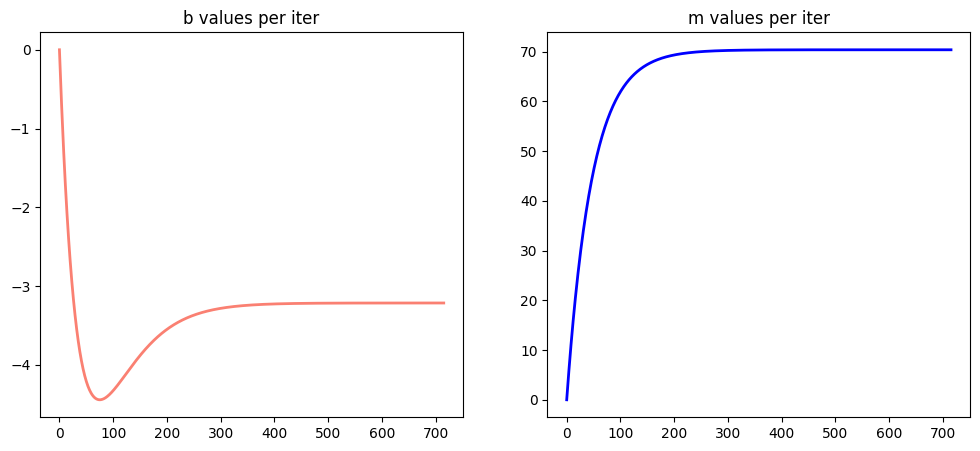

In [ ]:
params = gradientDescent(train_x.reshape((len(train_x),)),
                         train_y,
                         cost=cost,
                         gradient=gradient,
                         initial_params=np.array([0,0]),
                         learning_rate=lambda x: 0.01,
                         max_iters=1000)

b: -3.215774524581884
m: 70.34843286766495
Iters: 6594


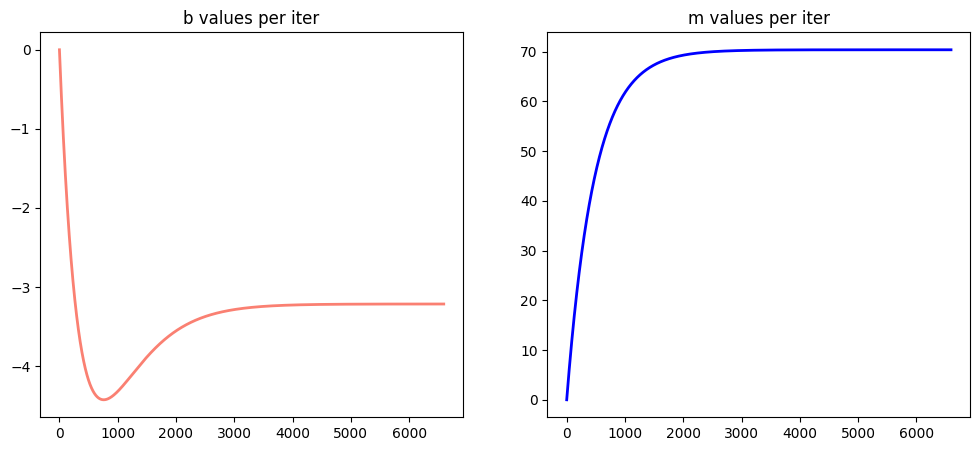

In [ ]:
params = gradientDescent(train_x.reshape((len(train_x),)),
                         train_y,
                         cost=cost,
                         gradient=gradient,
                         initial_params=np.array([0,0]),
                         learning_rate=lambda x: 0.001,
                         max_iters=6700)

## Minimum Squares Exact Solution

If $X^TX$ is an invertible matrix, with

$$X = \begin{bmatrix}1 & x_{1} \\  1 & x_{2} \\ \vdots & \vdots \\ 1 & x_{n}\end{bmatrix}$$

Then the optimal parameters $\theta = \begin{bmatrix}\theta_0 \\ \theta_1 \end{bmatrix}$ for a single variable linear regression
$$\hat{y}(x) = \begin{bmatrix}1 & x\end{bmatrix}\begin{bmatrix}\theta_0 \\ \theta_1 \end{bmatrix} = \theta_0 + x\theta_1,$$

are determined by the equation
$$\theta = (X^TX)^{-1}X^Ty,$$

where
$$y = \begin{bmatrix}y_{1} \\  y_{2} \\ \vdots \\ y_{n}\end{bmatrix}$$

Exact solution: ŷ = 70.3486x + -3.2157


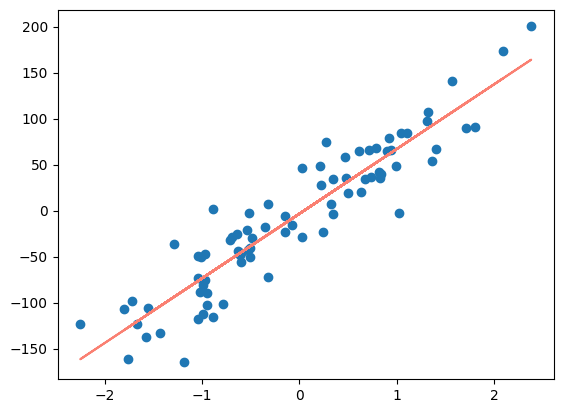

In [ ]:
X = np.concat((np.ones_like(train_x), train_x), axis=1)
Y = train_y.reshape(-1, 1)

params = (np.linalg.inv(X.T @ X) @ X.T @ Y).reshape(2,)
print(f"Exact solution: ŷ = {params[1]:.4f}x + {params[0]:.4f}")

yhat = lambda x: params[1] * x + params[0]

optimal_y_pred = [yhat(x) for x in train_x]

plt.scatter(train_x, train_y)
plt.plot(train_x, optimal_y_pred, c='salmon');